<a href="https://colab.research.google.com/github/aadhil96/pneumonia-Detection-from-Chest-X-Ray-Images-CNN/blob/main/neumonia_Detection_from_Chest_X_Ray_Images_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aadhilimam","key":"5229a84b438c67382805cf0403396ae9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:32<00:00, 53.9MB/s]
100% 2.29G/2.29G [00:32<00:00, 76.7MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [6]:
# Basics
import numpy as np 
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,  SeparableConv2D, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

In [7]:
#Reading the images with larger size might take longer
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
#Setting to 1200 might help. For memory concern, I set it to 200.
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                # I really tried to keep the RGB. But Kaggle keeps throwing memory error.
                # I also tried to keep image size larger. Kaggle keeps throwing memory error in data augmentation.
                # So I set img size to 200 and read in the images with grayscale. 
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
train = get_data('/content/files/chest_xray/chest_xray/train')
test = get_data('/content/files/chest_xray/chest_xray/test')
val = get_data('/content/files/chest_xray/chest_xray/val')

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [8]:
#Routines for feature label separation.
#Put the features into a list of arrays.
#Put the label into y variable.
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
    
#del train
#del test
#del val

In [9]:
#Normalize Images
def normalize_image(img_set):
    img_set = np.array(img_set)/255
    return img_set
x_train = normalize_image(x_train)
x_val = normalize_image(x_val)
x_test = normalize_image(x_test)

#Resize for transfer learning 
def train_reshape(img_set):
    img_set = img_set.reshape(-1,img_size, img_size, 1)
    return img_set
x_train = train_reshape(x_train)
x_val = train_reshape(x_val)
x_test = train_reshape(x_test)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [10]:
# We try to increase the train set with augmentation as much as possible. 
# However, rotation might influence the prediction.
datagen = ImageDataGenerator(
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.05,  # randomly shift images horizontally (fraction of total width)
        horizontal_flip = False) # I set this to true at first. It is horrible for the model to detect.
datagen.fit(x_train)

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.applications import *
from keras.models import Model
import keras

In [20]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, mode="max")

callback_list = [monitor, learning_rate_reduction]

In [21]:
input_layer = tf.keras.layers.Input([200,200,1])

conv1 = tf.keras.layers.Conv2D(filters = 32 , kernel_size = (5,5) , padding ='Same',
        activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))( conv1)

conv2 = tf.keras.layers.Conv2D(filters = 64 , kernel_size = (3,3) , padding ='Same',
        activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2) , strides=(2,2))(conv2)

conv3 = tf.keras.layers.Conv2D(filters = 96 , kernel_size = (3,3) , padding ='Same',
        activation='relu')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2) , strides=(2,2))(conv3)

conv4 = tf.keras.layers.Conv2D(filters = 96 , kernel_size = (3,3) , padding ='Same',
        activation='relu')(pool3)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2) , strides=(2,2))(conv4)

flatten = tf.keras.layers.Flatten()(pool4)
dense = tf.keras.layers.Dense(512 , activation = 'relu')(flatten)
out = tf.keras.layers.Dense(1 , activation='sigmoid' )(dense)

model = tf.keras.Model(input_layer , out)

model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
history = model.fit(datagen.flow(x_train,y_train, batch_size = 8) ,epochs = 30 , \
                    validation_data = datagen.flow(x_val, y_val) , callbacks = callback_list )

Epoch 1/30
652/652 [==============================] - 17s 26ms/step - loss: 0.5001 - accuracy: 0.7873 - val_loss: 0.7800 - val_accuracy: 0.6250
Epoch 2/30
652/652 [==============================] - 16s 25ms/step - loss: 0.2445 - accuracy: 0.9025 - val_loss: 1.0380 - val_accuracy: 0.5625
Epoch 3/30
652/652 [==============================] - 16s 25ms/step - loss: 0.2065 - accuracy: 0.9139 - val_loss: 0.9343 - val_accuracy: 0.6250
Epoch 4/30
652/652 [==============================] - 16s 25ms/step - loss: 0.1857 - accuracy: 0.9283 - val_loss: 0.8379 - val_accuracy: 0.6875
Epoch 5/30
652/652 [==============================] - 16s 25ms/step - loss: 0.1706 - accuracy: 0.9320 - val_loss: 0.7430 - val_accuracy: 0.8750
Epoch 6/30
652/652 [==============================] - 17s 25ms/step - loss: 0.1473 - accuracy: 0.9482 - val_loss: 2.6421 - val_accuracy: 0.6250
Epoch 7/30
652/652 [==============================] - 17s 25ms/step - loss: 0.1428 - accuracy: 0.9427 - val_loss: 0.6659 - val_accuracy:

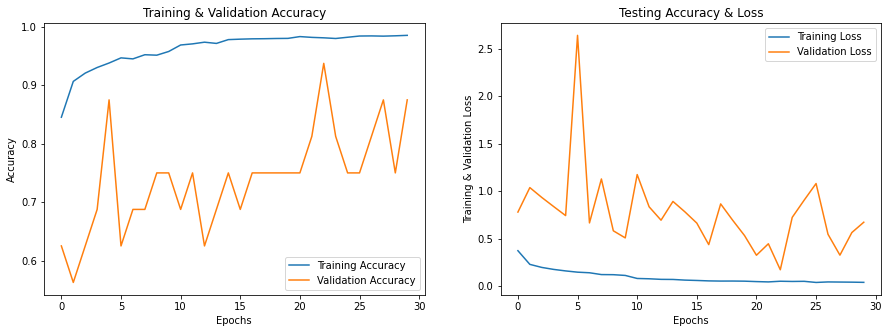

In [22]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc  , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc  , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss  , label = 'Training Loss')
ax[1].plot(epochs , val_loss  , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [23]:
print("Loss " , model.evaluate(x_test,y_test)[0])
print("Accuracy" , model.evaluate(x_test,y_test))

20/20 [==============================] - 1s 15ms/step - loss: 0.6510 - accuracy: 0.9022
Loss  0.6509785056114197
20/20 [==============================] - 0s 15ms/step - loss: 0.6510 - accuracy: 0.9022
Accuracy [0.6509785056114197, 0.9022436141967773]


In [24]:
model.save('Pneumonia.h5')